# Plotting notebook for demonstrating reproduced results
In this notebook, all results of the reproduced experiments will be shown. All results shown in this notebook were created by running their respective experiment notebooks.
Experiment plots include:
- Measuring performance on vanilla strategic classification
- Examining performance in semi-strategic classification
- Monitoring accuracy while regularizing for social burden
- Monitoring accuracy while regularizing for utility
- Monitoring accuracy while regularizing for recourse

In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time
import matplotlib.patches as mpatches
import json
import random
import math
import os, psutil
from datetime import datetime
import pickle

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIG_SIZE = 14

# *Evaluating socially-aware performance*
Traditionally, strategic classification is only focused on optimizing performance, which can result in socially unfavourable situations in real life. To combat this issue, the authors proposed regularizing the models based three metrics: social burden, utility and recourse. Regularization was applied to the learning objective of the model according to the equation shown per metric. During the experiment, the amount of regularization was varied and the accuracy was monitored.

As visible below, the model is able to perform strategic classification relatively well on different datasets even though the model is being regularized.

## Social burden VS accuracy
Social burden can be defined as the minimum cost a positively-labeled user must incur to be classified correctly. The plot below was regularized according to social burden.

$R_{burden} = \sum \min c(x,x')$

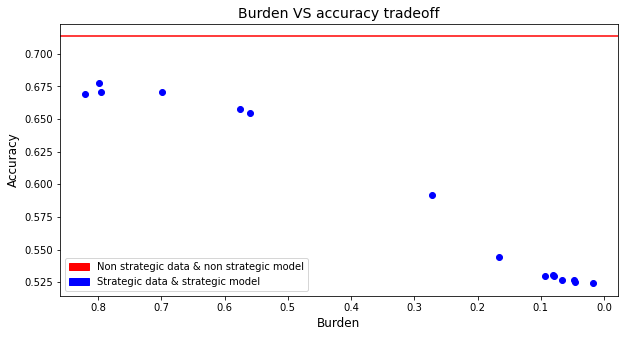

In [2]:
# Path to original burden model
# path = "./models/FINAL/burden/tradeoff"
# Path to reproduced model
path = "./models/burden"

burdens = []
accuracies = []
lambdas = []

# Loop through result folders
for root,d_names,f_names in os.walk(path):
    if "val_burdens.csv" in f_names:
        lamb = root.split("/")[-1].split("_")[-1]
        lambdas.append(lamb)
        val_burdens = pd.read_csv(root + '/val_burdens.csv')
        burden = val_burdens.values[-1][1]
        burdens.append(burden)
        # Save results to array
        val_errors = pd.read_csv(root + '/val_errors.csv')
        acc = 1 - val_errors.values[-1][1]
        accuracies.append(acc)

# Plot figure
fig = plt.figure(figsize=(10,5))

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Burden VS accuracy tradeoff')
plt.xlabel('Burden')
plt.ylabel('Accuracy')
plt.scatter(burdens, accuracies, color='b')
plt.axhline(y=0.7133, linestyle='-', color='r')
plt.gca().invert_xaxis()

red_patch = mpatches.Patch(color='r', label='Non strategic data & non strategic model')
blue_patch = mpatches.Patch(color='b', label='Strategic data & strategic model')

plt.legend(handles=[red_patch, blue_patch])
plt.show()

## Utility VS accuracy
Utility can be defined as the social good/utility gained by modifying their features. The plot below was regularized according to utility.

$R_{utility} = -\sum^m_{i=1} h(\Delta(x)) - c(x,\Delta(x)) $

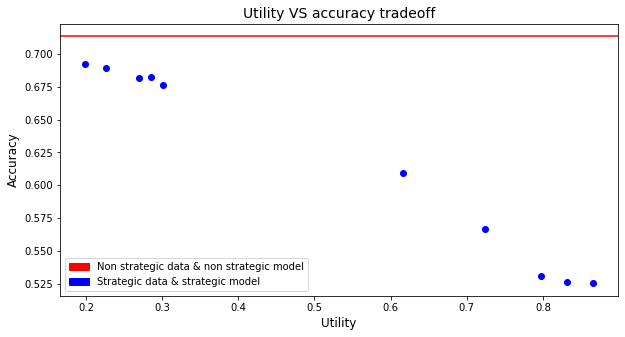

In [3]:
# Path to original utility model
# path = "./models/FINAL/utility/tradeoff"
# Path to reproduced model
path = "./models/utility"

utilities = []
accuracies = []
lambdas = []

# Loop through result folders
for root,d_names,f_names in os.walk(path):
    if "val_utilities.csv" in f_names:
        lamb = root.split("/")[-1].split("_")[-1]
        lambdas.append(lamb)
        val_utilities = pd.read_csv(root + '/val_utilities.csv')
        utility = val_utilities.values[-1][1]
        utilities.append(utility)
        val_errors = pd.read_csv(root + '/val_errors.csv')
        # Save results to array
        acc = 1 - val_errors.values[-1][1]
        accuracies.append(acc)

# Plot figure
fig = plt.figure(figsize=(10,5))

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Utility VS accuracy tradeoff')
plt.xlabel('Utility')
plt.ylabel('Accuracy')
plt.scatter(utilities, accuracies, color='b')
plt.axhline(y=0.7133, linestyle='-', color='r')
red_patch = mpatches.Patch(color='r', label='Non strategic data & non strategic model')
blue_patch = mpatches.Patch(color='b', label='Strategic data & strategic model')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

## Recourse VS accuracy
Recourse can be defined as the capacity of a user who is denied a service to restore approval through reasonable
action. The plot below was regularized according to recourse.

$ R_{recourse} = \sum^m_{i=1}\sigma(-f(x)) * \sigma(-f(\Delta_f(x)))$

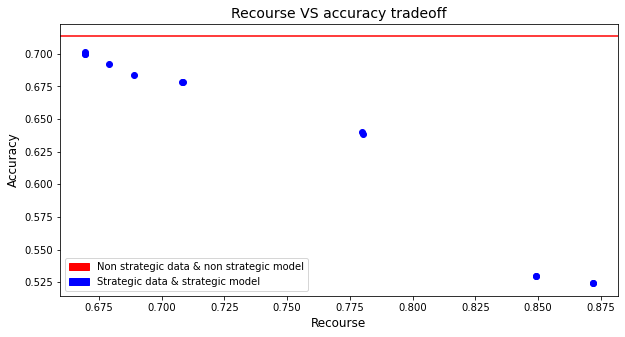

In [4]:
# Path to original recourse model
# path = "./models/FINAL/recourse/tradeoff"
# Path to reproduced recourse model
path = "./models/recourse"

recourses = []
accuracies = []
lambdas = []

# Loop through result folders
for root,d_names,f_names in os.walk(path):
    if "val_recourses.csv" in f_names:
        lamb = root.split("/")[-1].split("_")[-1]
        lambdas.append(lamb)
        val_recourses = pd.read_csv(root + '/val_recourses.csv')
        recourse = val_recourses.values[-1][1]
        recourses.append(recourse)
        # Save results to array
        val_errors = pd.read_csv(root + '/val_errors.csv')
        acc = 1 - val_errors.values[-1][1]
        accuracies.append(acc)

# Plot figure
fig = plt.figure(figsize=(10,5))
plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Recourse VS accuracy tradeoff')
plt.xlabel('Recourse')
plt.ylabel('Accuracy')
plt.scatter(recourses, accuracies, color='b')
plt.axhline(y=0.7133, linestyle='-', color='r')

red_patch = mpatches.Patch(color='r', label='Non strategic data & non strategic model')
blue_patch = mpatches.Patch(color='b', label='Strategic data & strategic model')

plt.legend(handles=[red_patch, blue_patch])
plt.show()

# *Examining model performance in different environments*

## Vanilla
This is the situation as proposed in the original proposal of strategic classification by Hardt et al. The model is a linear classifier trained on the SERM objective, performance is measured.

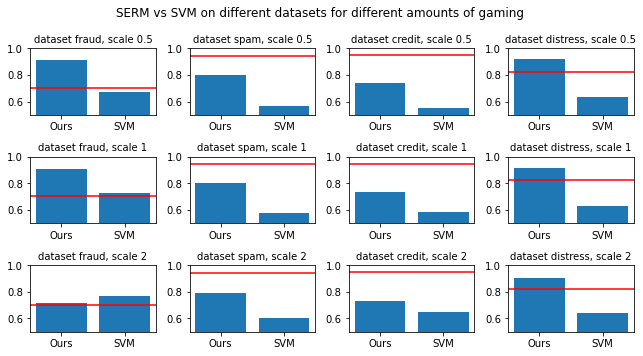

In [5]:
# Path to original model
path_svm = "./models/FINAL/vanilla_II"
# Path to reproducded model
path = "./models/vanilla_quad"
all_results = dict()
splits = 1

svm_accuracies = pd.read_csv(path_svm + '/svm_accuracies.csv').values[:, 1]

# Loop through result folders
for root,d_names,f_names in os.walk(path):
    if "results.csv" in f_names:
        details = root.split("/")
        scale = details[-1]
        dataset = details[-3]
        # Save results to array
        acc = pd.read_csv(root + '/results.csv')
        acc = acc.values[:, 1]
        if (scale, dataset) not in all_results:
            all_results[(scale, dataset)] = np.zeros(3)
        all_results[(scale, dataset)] += acc
for key in all_results:
    all_results[key] /= splits

# Plot figure
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(9, 5))
fig.suptitle("SERM vs SVM on different datasets for different amounts of gaming")

for i, (scale, dataset) in enumerate(all_results):
    row = i % 3
    col = i // 3
    axes[row, col].bar(["Ours", "SVM"], all_results[(scale, dataset)][1:])
    axes[row, col].set_ylim(0.5, 1) 
    axes[row, col].axhline(y=svm_accuracies[col], linestyle='-', color='r')
    axes[row,col].set_title("dataset {}, scale {}".format(dataset,scale),fontsize=10)
    
fig.tight_layout()

plt.show()

# Semi-strategic classification
This section demonstrates the new experiment that was done in our reproduction: examining performance of the proposed model in a situation where the amount of gaming users ranges from 0% to 100%.
The following plots show the results of the model when performing strategic classification on the used datasets. The first section shows the false positive and false negative rates as the amount of gaming users increase, while the second section shows the classification accuracy as the amount of gaming users increase.

/home/alex/anaconda3/envs/scmp2/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/home/alex/anaconda3/envs/scmp2/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/alex/anaconda3/envs/scmp2/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/home/alex/anaconda3/envs/scmp2/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/alex/anaconda3/envs/scmp2/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/home/alex/anac

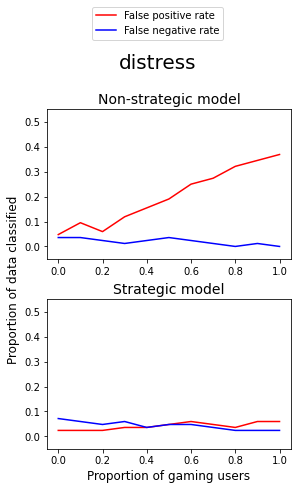

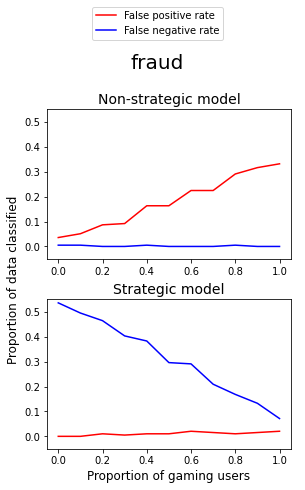

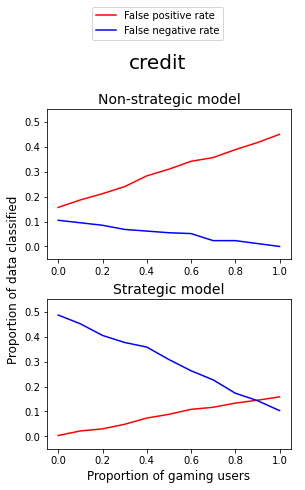

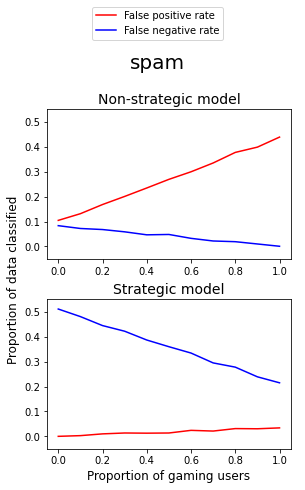

In [7]:
path = "experiment_results"
errors = pickle.load(open(path + '/errors.dump', 'rb'))
results = pickle.load(open(path + '/accuracies.dump', 'rb'))
betas = np.arange(0.0, 1.1, 0.1)

for dataset in errors:
    ns_FP, ns_FN, s_FP, s_FN, name = dataset
    fig, ax = plt.subplots(2)
    fig.set_size_inches(4, 6)
    ax[0].set_title("Non-strategic model")
    l1 = ax[0].plot(betas, ns_FP, 'r', label='False positives')
    l2 = ax[0].plot(betas, ns_FN, 'b', label='False negatives')
    ax[0].set_ylim([-0.05, 0.55])

    ax[1].set_title("Strategic model")
    l3 = ax[1].plot(betas, s_FP, 'r', label='False positives')
    l4 = ax[1].plot(betas, s_FN, 'b', label='False negatives')
    ax[1].set_ylim([-0.05, 0.55])

    fig.legend([l1, l2], labels=['False positive rate','False negative rate'], loc='lower center', 
                                       bbox_to_anchor=(0.5, 1)
                                      )
    fig.tight_layout()
    fig.suptitle(name, fontsize=20)
    plt.subplots_adjust(top=0.85)
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.ylabel("Proportion of data classified")
    plt.xlabel("Proportion of gaming users")
    fig.show()

/home/alex/anaconda3/envs/scmp2/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


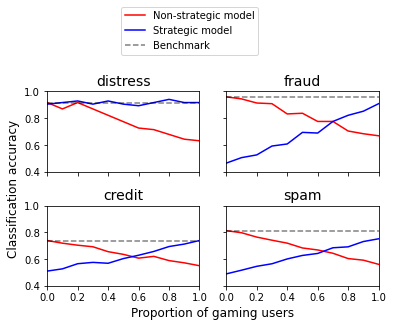

In [8]:
fig, ax = plt.subplots(2, 2)

fig.add_subplot(111, frameon=False)
for idx, (acc_nonstr, acc_str, name) in enumerate(results):
    a = ax[idx//2, idx%2]
    a.set_title(name)
    l1 = a.plot(betas, acc_nonstr, 'r', label='Non-strategic model')
    l2 = a.plot(betas, acc_str, 'b', label='Strategic model')
    l3 = a.axhline(y = acc_nonstr[0], color = 'black', linestyle = '--', alpha=0.5)
    a.set_ylim([0.4, 1])
    a.set_xlim([0, 1])

for ax in fig.get_axes():
    ax.label_outer()

fig.legend([l1, l2, l3], labels=['Non-strategic model','Strategic model', 'Benchmark'], loc='lower center', 
           bbox_to_anchor=(0.5, 1)
          )


plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("Classification accuracy")
plt.xlabel("Proportion of gaming users")
plt.tight_layout()